In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from src.utils.utils import my_most_common, sentiment_postprocessor, sentiment_preprocessor
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

RANDOM_STATE = 42
PANDARALLEL_WORKERS = 8


def sentiment_preprocessor(label):
    if label >= 1:
        return "позитив"
    elif label == 0:
        return "нейтральность"
    elif label <= -1:
        return "негатив"

In [ ]:
def get_linis_crowd():
    linis_crowd_2015_path = "data/linis-crowd-2015/text_rating_final.xlsx"
    linis_crowd_2016_path = "data/linis-crowd-2016/doc_comment_summary.xlsx"
    column_names = ["text", "label"]

    linis_crowd_2016 = pd.read_excel(linis_crowd_2016_path, header=None, names=column_names).dropna()
    linis_crowd_2016 = linis_crowd_2016[linis_crowd_2016["label"].isin([-2, -1, 0, 1, 2])].copy()

    linis_crowd_2016["label"] = linis_crowd_2016["label"].apply(sentiment_preprocessor)
    linis_crowd_2016["text"] = linis_crowd_2016["text"].apply(lambda x: x.replace("\n", " ").replace("\t", ""))

    linis_crowd_2015 = pd.read_excel(linis_crowd_2015_path, header=None, names=column_names).dropna()
    linis_crowd_2015 = linis_crowd_2015[linis_crowd_2015["label"].isin([-2, -1, 0, 1, 2])].copy()

    linis_crowd_2015["label"] = linis_crowd_2015["label"].apply(sentiment_preprocessor)
    linis_crowd_2015["text"] = linis_crowd_2015["text"].apply(lambda x: x.replace("\n", " ").replace("\t", ""))

    linis_crowd = pd.concat([linis_crowd_2015, linis_crowd_2016], ignore_index=True)

    pandarallel.initialize(progress_bar=True, nb_workers=PANDARALLEL_WORKERS)

    linis_crowd["occur"] = linis_crowd["text"].parallel_apply(lambda x: (linis_crowd["text"] == x).sum())

    processed_linis_crowd = linis_crowd[linis_crowd["occur"] >= 3]

    unique_mapping = {}

    for index, row in processed_linis_crowd.iterrows():
        if row["text"] in unique_mapping:
            unique_mapping[row["text"]].append(row["label"])
        else:
            unique_mapping[row["text"]] = [row["label"]]

    final_df_map = {}

    for key in unique_mapping:
        most_common = my_most_common(unique_mapping[key])
        if most_common is not False:
            final_df_map[key] = most_common

    final_linis_crowd = pd.DataFrame(final_df_map.items(), columns=column_names)
    return final_linis_crowd

In [ ]:
linis_crowd = get_linis_crowd()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
linis_crowd["text"]

0       Не рациональная системность, а интуитивный поз...
1       Когда возникнут трудности, они тебе не помогут...
2       Кривая национализация это политический компром...
3       Такой вид биологического оружия не действует н...
4       В Эль-Кусейре /к западу от Хомса/ сирийские по...
                              ...                        
5861    Зачем разглагольствовать на тему как сделано в...
5862    Самые умные и те, кому надо влезть быстрее все...
5863    А нет желания поднять вопрос о нарушении УК де...
5864    html  Реальный шанс выкарабкаться из дерьма дл...
5865    т Януковича спокойно избавится в любой момент ...
Name: text, Length: 5866, dtype: object

In [ ]:
pd.options.display.max_colwidth = 80

In [ ]:
linis_crowd.sample(3)

,text,label
944,"флагманский корабль ВМС Азербайджана СКР G-121 Гусары, бывший СКР проекта 15...",нейтральность
2652,К назначению пребиотиков в развитых странах относятся с осторожностью. 4. Ва...,негатив
5654,"атрешек : ну да, древности же :-) World Wide Web :-) ну да, ну да ... н...",позитив


In [ ]:
linis_crowd["Length words"] = linis_crowd["text"].apply(lambda x: len(x.split()))
linis_crowd["Length"] = linis_crowd["text"].apply(len)

In [ ]:
linis_crowd["Length words"].mean()

149.0487555404023

In [ ]:
linis_crowd["Length"].mean()

1073.2083191271736

In [ ]:
len(linis_crowd)

5866

In [ ]:
linis_crowd.groupby("label").sample(2)[["text", "label"]]

,text,label
2165,"18 марта в Стамбуле, как мы уже сообщали, состоялись так называемые выборы Н...",негатив
829,"Не важно, сколькими духовными реализациями мы обладаем: до тех пор, пока в н...",негатив
4896,Смотрю. Потому и вопрос - что время пришло Лунтика в расход? Я.Надеюсь что...,нейтральность
5527,"если лицо отказавшееся от полномочий, тут же наделяется этими полномочиями с...",нейтральность
1183,Глубокую рецитации мантры вы завершаете кратким подношением и восхвалением (...,позитив
1711,"Как бы вы прокомментировали это мнение? Доктор Лайтнер: Да, существует миф с...",позитив


In [ ]:
linis_crowd_2016["label"]

0              негатив
1              негатив
2              негатив
3        нейтральность
4        нейтральность
             ...      
26868          негатив
26869          негатив
26870    нейтральность
26871    нейтральность
26872    нейтральность
Name: label, Length: 26752, dtype: object

<AxesSubplot: xlabel='Количество элементов', ylabel='Класс'>

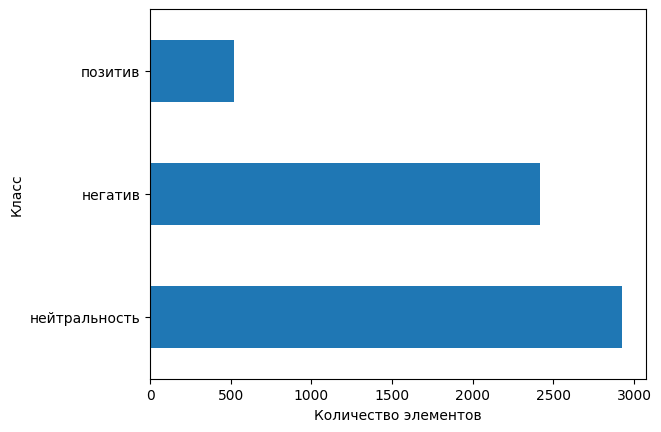

In [ ]:
linis_crowd["label"].value_counts().plot.barh(xlabel="Количество элементов", ylabel="Класс")